In [16]:
import numpy as np
import pandas as pd
from sklearn import metrics, model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

In [2]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.008697,0.0,0.000000,0.0,0.0,0.042426,0.003253,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.007640,0.0,1.154701,0.0,0.0,0.055076,0.044573,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.028117,0.0,1.000000,0.0,0.0,0.076322,0.037977,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.025953,0.0,1.095445,0.0,0.0,0.073621,0.033498,187,0,0


In [3]:
df_test = pd.read_csv('data/test.csv')
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,sd15,sd16,sd17,sd18,sd19,sd20,sd21,ttf,label_bnc,label_mcc
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,0.021174,0.0,0.707107,0.0,0.0,0.124016,0.025037,112,0,0
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,0.011429,0.0,1.095445,0.0,0.0,0.069785,0.027820,98,0,0
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,0.030924,0.0,0.836660,0.0,0.0,0.143631,0.018966,69,0,0
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,0.021249,0.0,1.341641,0.0,0.0,0.126372,0.021106,82,0,0
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,0.009627,0.0,0.547723,0.0,0.0,0.091924,0.101100,91,0,0


In [4]:
features_orig = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

features_extr = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 'av1', 'av2', 'av3', 'av4', 'av5', 'av6', 'av7', 'av8', 'av9', 'av10', 'av11', 'av12', 'av13', 'av14', 'av15', 'av16', 'av17', 'av18', 'av19', 'av20', 'av21', 'sd1', 'sd2', 'sd3', 'sd4', 'sd5', 'sd6', 'sd7', 'sd8', 'sd9', 'sd10', 'sd11', 'sd12', 'sd13', 'sd14', 'sd15', 'sd16', 'sd17', 'sd18', 'sd19', 'sd20', 'sd21']

y_train = df_train['label_bnc']
y_test = df_test['label_bnc']

In [5]:
def bin_classify(model, clf, features, params=None, score=None):
    X_train = df_train[features]

    X_test = df_test[features] 
    
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    if hasattr(grid_search, 'predict_proba'):   
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
        
    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    return grid_search.best_estimator_, df_predictions

In [6]:
def bin_class_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):
      
    binclass_metrics = {
                        'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                        'Precision' : metrics.precision_score(y_test, y_pred),
                        'Recall' : metrics.recall_score(y_test, y_pred),
                        'F1 Score' : metrics.f1_score(y_test, y_pred),
                        'ROC AUC' : metrics.roc_auc_score(y_test, y_score)
                       }

    df_metrics = pd.DataFrame.from_dict(binclass_metrics, orient='index')
    df_metrics.columns = [model]  


    fpr, tpr, thresh_roc = metrics.roc_curve(y_test, y_score)
    
    roc_auc = metrics.auc(fpr, tpr)

    engines_roc = []  
    for thr in thresh_roc:  
        engines_roc.append((y_score >= thr).mean())

    engines_roc = np.array(engines_roc)

    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'Que' : engines_roc
                 }
    
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    
    #calculate other classification metrics: TP, FP, TN, FN, TNR, FNR
    #from ground truth file, positive class = 25 => TP + FN = 25
    #from ground truth file, negative class = 75 => TN + FP = 75
    
    df_roc_thresh['TP'] = (25*df_roc_thresh.TPR).astype(int)
    df_roc_thresh['FP'] = (25 - (25*df_roc_thresh.TPR)).astype(int)
    df_roc_thresh['TN'] = (75*(1 - df_roc_thresh.FPR)).astype(int)
    df_roc_thresh['FN'] = (75 - (75*(1 - df_roc_thresh.FPR))).astype(int)
    
    df_roc_thresh['TNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FN'])
    df_roc_thresh['FNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FP'])
    
    df_roc_thresh['Model'] = model

    

    precision, recall, thresh_prc = metrics.precision_recall_curve(y_test, y_score)

    thresh_prc = np.append(thresh_prc,1)

    engines_prc = []  
    for thr in thresh_prc:  
        engines_prc.append((y_score >= thr).mean())

    engines_prc = np.array(engines_prc)

    prc_thresh = {
                    'Threshold' : thresh_prc,
                    'Precision' : precision,
                    'Recall' : recall,
                    'Que' : engines_prc
                 }

    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)

    if print_out:
        print('-----------------------------------------------------------')
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test, y_pred))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test, y_pred))
        print('\nMetrics:')
        print(df_metrics)

        print('\nROC Thresholds:\n')
        print(df_roc_thresh[['Threshold', 'TP', 'FP', 'TN', 'FN', 'TPR', 'FPR', 'TNR','FNR', 'Que']])

        print('\nPrecision-Recall Thresholds:\n')
        print(df_prc_thresh[['Threshold', 'Precision', 'Recall', 'Que']])

    if plot_out:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False )
        fig.set_size_inches(10,10)

        ax1.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f'% roc_auc)
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right", fontsize='small')

        ax2.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left", fontsize='small')

        ax3.plot(thresh_roc, fpr, color='red', lw=2, label='FPR')  
        ax3.plot(thresh_roc, tpr, color='green',label='TPR') 
        ax3.plot(thresh_roc, engines_roc, color='blue',label='Engines') 
        ax3.set_ylim([0.0, 1.05])
        ax3.set_xlabel('Threshold')  
        ax3.set_ylabel('%')
        ax3.legend(loc='upper right', fontsize='small')

        ax4.plot(thresh_prc, precision, color='red', lw=2, label='Precision')  
        ax4.plot(thresh_prc, recall, color='green',label='Recall') 
        ax4.plot(thresh_prc, engines_prc, color='blue',label='Engines') 
        ax4.set_ylim([0.0, 1.05])
        ax4.set_xlabel('Threshold')  
        ax4.set_ylabel('%')
        ax4.legend(loc='lower left', fontsize='small')

    return  df_metrics, df_roc_thresh, df_prc_thresh


__In model names:__  

__B__ stands for applying the model on the original features set, __B__efore feature extraction  
__A__ stands for applying the model on the original + extracted features set, __A__fter feature extraction  


Best Parameters:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
-----------------------------------------------------------
Logistic Regression B 

Confusion Matrix:
[[73  2]
 [11 14]]

Classification Report:
             precision    recall  f1-score   support

          0       0.87      0.97      0.92        75
          1       0.88      0.56      0.68        25

avg / total       0.87      0.87      0.86       100


Metrics:
           Logistic Regression B
Accuracy                0.870000
Precision               0.875000
Recall                  0.560000
F1 Score                0.682927
ROC AUC                 0.980267

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    0.993269   1  24  75   0  0.04  0.000000  1.000000  0.7575

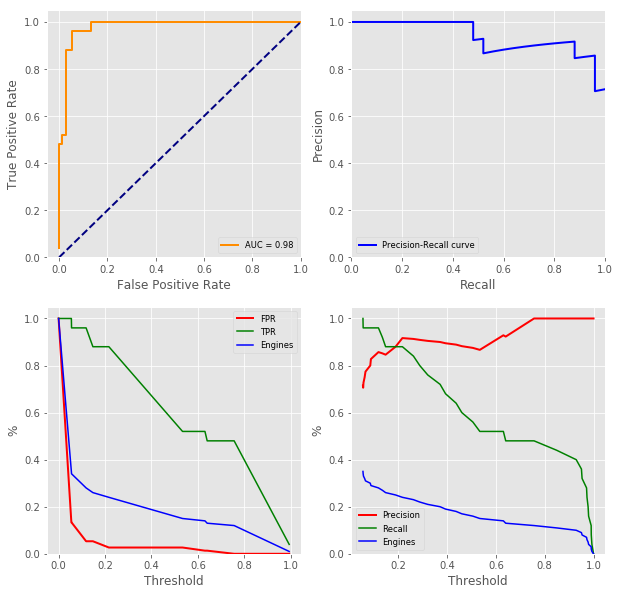

In [9]:
model = 'Logistic Regression B'
clf_lgrb = LogisticRegression(random_state=123)
gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'

clf_lgrb, pred_lgrb = bin_classify(model, clf_lgrb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_lgrb)

metrics_lgrb, roc_lgrb, prc_lgrb = bin_class_metrics(model, y_test, pred_lgrb.y_pred, pred_lgrb.y_score, print_out=True, plot_out=True)


Best Parameters:
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
-----------------------------------------------------------
Logistic Regression A 

Confusion Matrix:
[[75  0]
 [ 8 17]]

Classification Report:
             precision    recall  f1-score   support

          0       0.90      1.00      0.95        75
          1       1.00      0.68      0.81        25

avg / total       0.93      0.92      0.91       100


Metrics:
           Logistic Regression A
Accuracy                0.920000
Precision               1.000000
Recall                  0.680000
F1 Score                0.809524
ROC AUC                 0.981867

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    0.994084   1  24  75   0  0.04  0.000000  1.000000  0.75757

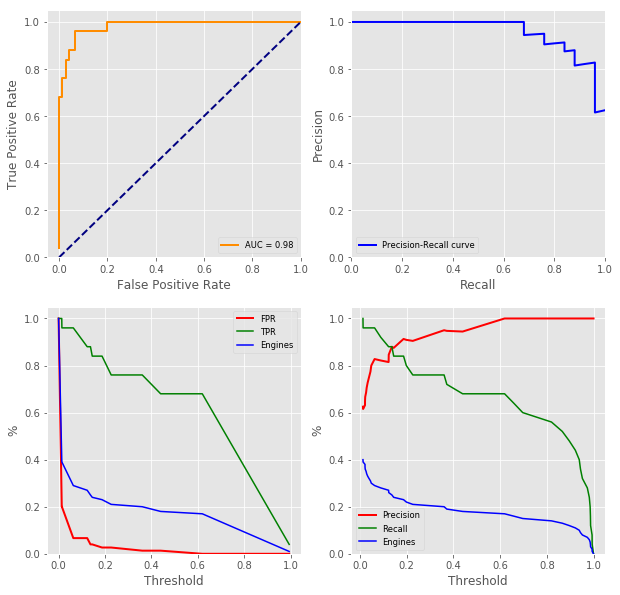

In [10]:
model = 'Logistic Regression A'
clf_lgra = LogisticRegression(random_state=123)
gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'

clf_lgra, pred_lgra = bin_classify(model, clf_lgra, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_lgra)

metrics_lgra, roc_lgra, prc_lgra = bin_class_metrics(model, y_test, pred_lgra.y_pred, pred_lgra.y_score, print_out=True, plot_out=True)

In [11]:
metrics_lgr = pd.concat([metrics_lgrb, metrics_lgra], axis=1)
metrics_lgr

,Logistic Regression B,Logistic Regression A
Accuracy,0.870000,0.920000
Precision,0.875000,1.000000
Recall,0.560000,0.680000
F1 Score,0.682927,0.809524
ROC AUC,0.980267,0.981867



Best Parameters:
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')
-----------------------------------------------------------
Decision Tree B 

Confusion Matrix:
[[74  1]
 [11 14]]

Classification Report:
             precision    recall  f1-score   support

          0       0.87      0.99      0.93        75
          1       0.93      0.56      0.70        25

avg / total       0.89      0.88      0.87       100


Metrics:
           Decision Tree B
Accuracy          0.880000
Precision         0.933333
Recall            0.560000
F1 Score          0.700000
ROC AUC           0.945067

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    1.000000   

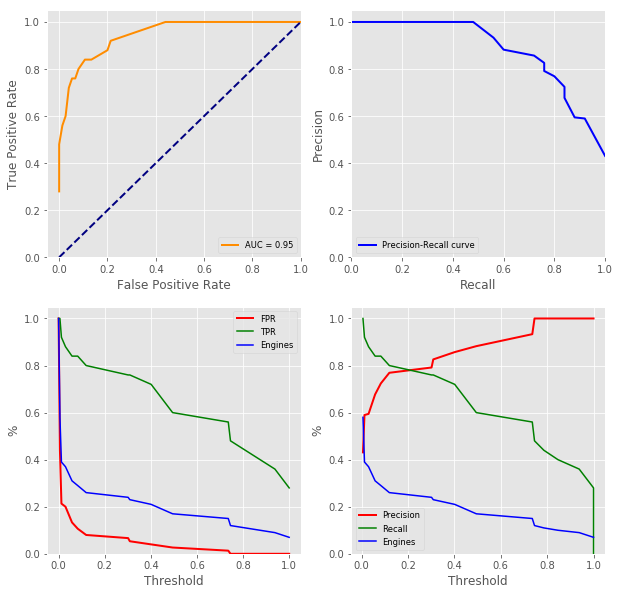

In [12]:
model = 'Decision Tree B'
clf_dtrb = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [2, 3, 4, 5, 6], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_dtrb, pred_dtrb = bin_classify(model, clf_dtrb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_dtrb)

metrics_dtrb, roc_dtrb, prc_dtrb = bin_class_metrics(model, y_test, pred_dtrb.y_pred, pred_dtrb.y_score, print_out=True, plot_out=True)


Best Parameters:
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')
-----------------------------------------------------------
Decision Tree A 

Confusion Matrix:
[[74  1]
 [ 7 18]]

Classification Report:
             precision    recall  f1-score   support

          0       0.91      0.99      0.95        75
          1       0.95      0.72      0.82        25

avg / total       0.92      0.92      0.92       100


Metrics:
           Decision Tree A
Accuracy          0.920000
Precision         0.947368
Recall            0.720000
F1 Score          0.818182
ROC AUC           0.962933

ROC Thresholds:

   Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0   1.000000  10 

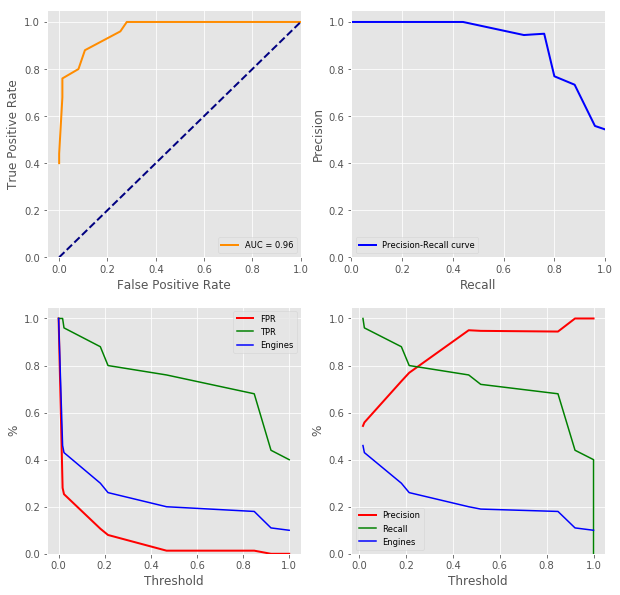

In [13]:
model = 'Decision Tree A'
clf_dtra = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [3, 4, 5, 6, 7], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_dtra, pred_dtra = bin_classify(model, clf_dtra, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_dtra)

metrics_dtra, roc_dtra, prc_dtra = bin_class_metrics(model, y_test, pred_dtra.y_pred, pred_dtra.y_score, print_out=True, plot_out=True)

In [14]:
metrics_dtr = pd.concat([metrics_dtrb, metrics_dtra], axis=1)
metrics_dtr

,Decision Tree B,Decision Tree A
Accuracy,0.880000,0.920000
Precision,0.933333,0.947368
Recall,0.560000,0.720000
F1 Score,0.700000,0.818182
ROC AUC,0.945067,0.962933



Best Parameters:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)
-----------------------------------------------------------
Random Forest B 

Confusion Matrix:
[[74  1]
 [ 8 17]]

Classification Report:
             precision    recall  f1-score   support

          0       0.90      0.99      0.94        75
          1       0.94      0.68      0.79        25

avg / total       0.91      0.91      0.90       100


Metrics:
           Random Forest B
Accuracy          0.910000
Precision         0.944444
Recall            0.680000
F1 Score          0.790698
ROC AUC           0.980267

ROC Thresholds:

    Threshold  TP  FP  TN  FN

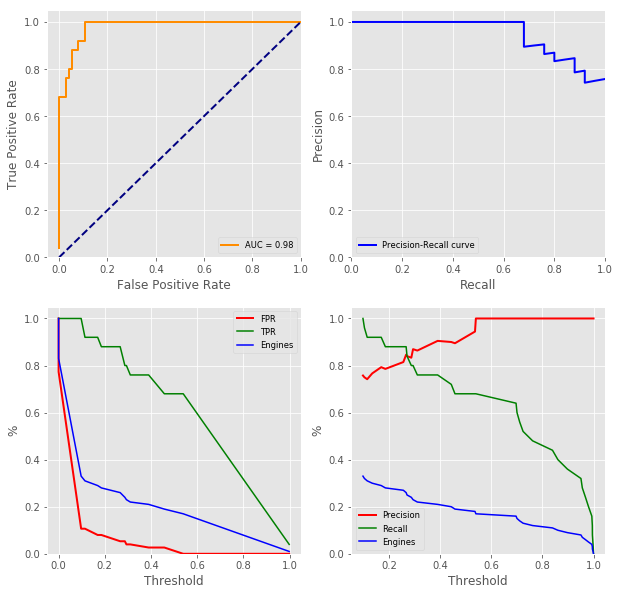

In [17]:
model = 'Random Forest B'
clf_rfcb = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_rfcb, pred_rfcb = bin_classify(model, clf_rfcb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_rfcb)

metrics_rfcb, roc_rfcb, prc_rfcb = bin_class_metrics(model, y_test, pred_rfcb.y_pred, pred_rfcb.y_score, print_out=True, plot_out=True)


Best Parameters:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)
-----------------------------------------------------------
Random Forest A 

Confusion Matrix:
[[74  1]
 [ 8 17]]

Classification Report:
             precision    recall  f1-score   support

          0       0.90      0.99      0.94        75
          1       0.94      0.68      0.79        25

avg / total       0.91      0.91      0.90       100


Metrics:
           Random Forest A
Accuracy          0.910000
Precision         0.944444
Recall            0.680000
F1 Score          0.790698
ROC AUC           0.982400

ROC Thresholds:

    Threshold  TP  FP  TN  FN

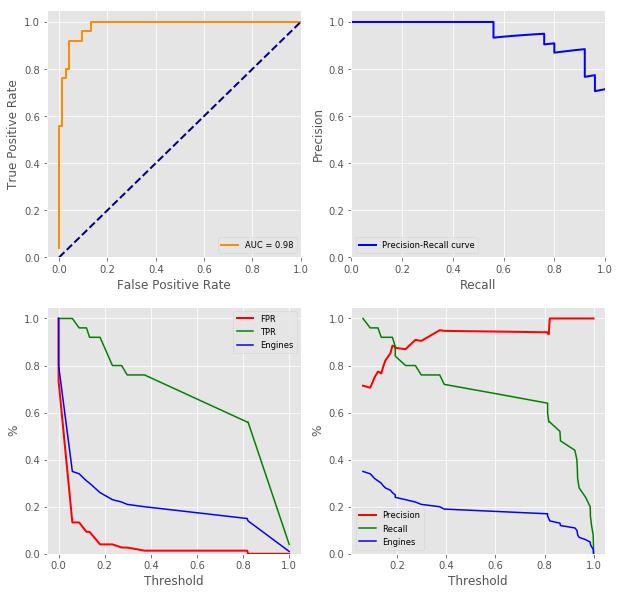

In [18]:
model = 'Random Forest A'
clf_rfca = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_rfca, pred_rfca = bin_classify(model, clf_rfca, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_rfca)

metrics_rfca, roc_rfca, prc_rfca = bin_class_metrics(model, y_test, pred_rfca.y_pred, pred_rfca.y_score, print_out=True, plot_out=True)

In [19]:
metrics_rfc = pd.concat([metrics_rfcb, metrics_rfca], axis=1)
metrics_rfc

,Random Forest B,Random Forest A
Accuracy,0.910000,0.910000
Precision,0.944444,0.944444
Recall,0.680000,0.680000
F1 Score,0.790698,0.790698
ROC AUC,0.980267,0.982400



Best Parameters:
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False)
-----------------------------------------------------------
SVC B 

Confusion Matrix:
[[74  1]
 [ 8 17]]

Classification Report:
             precision    recall  f1-score   support

          0       0.90      0.99      0.94        75
          1       0.94      0.68      0.79        25

avg / total       0.91      0.91      0.90       100


Metrics:
              SVC B
Accuracy   0.910000
Precision  0.944444
Recall     0.680000
F1 Score   0.790698
ROC AUC    0.891733

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    1.405108   1  24  75   0  0.04  0.000000  1.000000  0.757576  0.01
1    0.730778  13  12  75   0  0.52  0.000000  1.000000  0.862069  0.13
2    0.633767  13  12  74   1  0.52  0.013333  0.

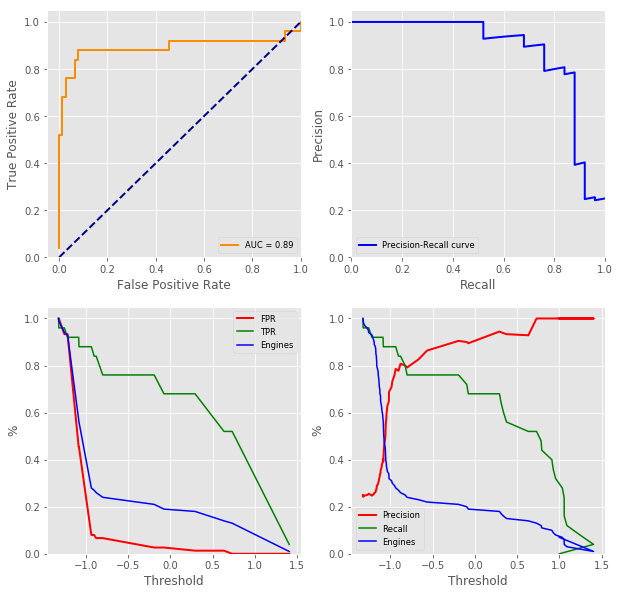

In [20]:
model = 'SVC B'
clf_svcb = SVC(kernel='rbf', random_state=123)
gs_params = {'C': [1.0]}
gs_score = 'roc_auc'

clf_svcb, pred_svcb = bin_classify(model, clf_svcb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_svcb)

metrics_svcb, roc_svcb, prc_svcb = bin_class_metrics(model, y_test, pred_svcb.y_pred, pred_svcb.y_score, print_out=True, plot_out=True)


Best Parameters:
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False)
-----------------------------------------------------------
SVC A 

Confusion Matrix:
[[74  1]
 [ 7 18]]

Classification Report:
             precision    recall  f1-score   support

          0       0.91      0.99      0.95        75
          1       0.95      0.72      0.82        25

avg / total       0.92      0.92      0.92       100


Metrics:
              SVC A
Accuracy   0.920000
Precision  0.947368
Recall     0.720000
F1 Score   0.818182
ROC AUC    0.930133

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    1.591611   1  24  75   0  0.04  0.000000  1.000000  0.757576  0.01
1    0.170041  17   8  75   0  0.68  0.000000  1.000000  0.903614  0.17
2    0.103133  17   8  74   1  0.68  0.013333  0.

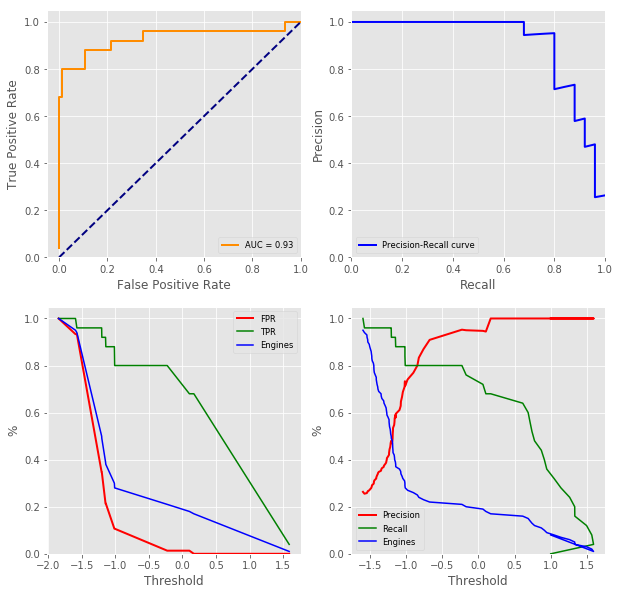

In [21]:
model = 'SVC A'
clf_svca = SVC(kernel='rbf', random_state=123)
gs_params = {'C': [1.0]}
gs_score = 'roc_auc'

clf_svca, pred_svca = bin_classify(model, clf_svca, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_svca)

metrics_svca, roc_svca, prc_svca = bin_class_metrics(model, y_test, pred_svca.y_pred, pred_svca.y_score, print_out=True, plot_out=True)

In [22]:
# Compare SVC Before and After FE
metrics_svc = pd.concat([metrics_svcb, metrics_svca], axis=1)
metrics_svc.sort_index()

,SVC B,SVC A
Accuracy,0.910000,0.920000
F1 Score,0.790698,0.818182
Precision,0.944444,0.947368
ROC AUC,0.891733,0.930133
Recall,0.680000,0.720000



Best Parameters:
 LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=123, tol=0.0001,
     verbose=0)
-----------------------------------------------------------
SVC Linear B 

Confusion Matrix:
[[75  0]
 [15 10]]

Classification Report:
             precision    recall  f1-score   support

          0       0.83      1.00      0.91        75
          1       1.00      0.40      0.57        25

avg / total       0.88      0.85      0.82       100


Metrics:
           SVC Linear B
Accuracy       0.850000
Precision      1.000000
Recall         0.400000
F1 Score       0.571429
ROC AUC        0.971733

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    0.833338   1  24  75   0  0.04  0.000000  1.000000  0.757576  0.01
1   -0.026667  11  14  75   0  0.44  0.000000  1.000000  0.842697  0.11
2   -0.049135  11  14  74   

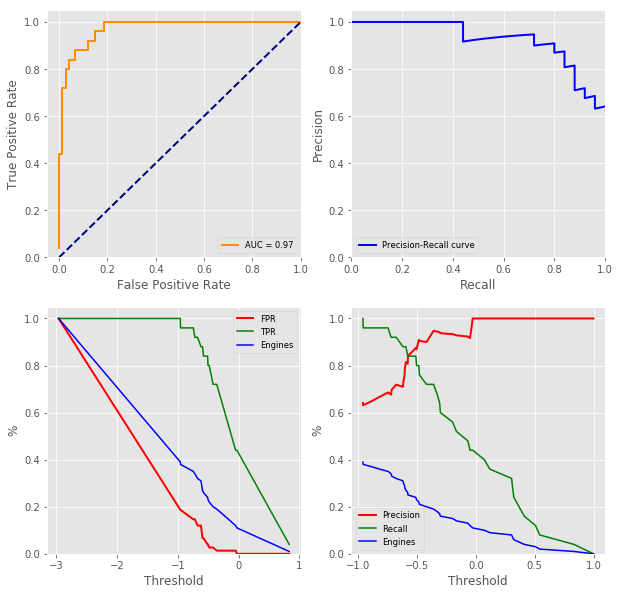

In [23]:
model = 'SVC Linear B'
clf_svlb = LinearSVC(random_state=123)
gs_params = {'C': [.01 ,.1 ,1.0]}
gs_score = 'roc_auc'

clf_svlb, pred_svlb = bin_classify(model, clf_svlb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_svlb)

metrics_svlb, roc_svlb, prc_svlb = bin_class_metrics(model, y_test, pred_svlb.y_pred, pred_svlb.y_score, print_out=True, plot_out=True)


Best Parameters:
 LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=123, tol=0.0001,
     verbose=0)
-----------------------------------------------------------
SVC Linear A 

Confusion Matrix:
[[42 33]
 [ 0 25]]

Classification Report:
             precision    recall  f1-score   support

          0       1.00      0.56      0.72        75
          1       0.43      1.00      0.60        25

avg / total       0.86      0.67      0.69       100


Metrics:
           SVC Linear A
Accuracy       0.670000
Precision      0.431034
Recall         1.000000
F1 Score       0.602410
ROC AUC        0.979733

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    1.915683   1  24  75   0  0.04  0.000000  1.000000  0.757576  0.01
1    1.226355  13  12  75   0  0.52  0.000000  1.000000  0.862069  0.13
2    1.166580  13  12  74  

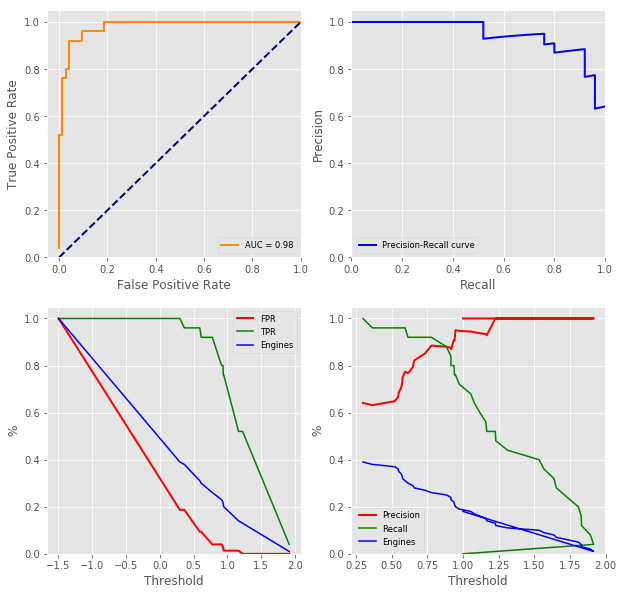

In [24]:
model = 'SVC Linear A'
clf_svla = LinearSVC(random_state=123)
gs_params = {'C': [.001, .01 ,.1 ]}
gs_score = 'roc_auc'

clf_svla, pred_svla = bin_classify(model, clf_svla, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_svla)

metrics_svla, roc_svla, prc_svla = bin_class_metrics(model, y_test, pred_svla.y_pred, pred_svla.y_score, print_out=True, plot_out=True)



In [25]:
# Compare Linear SVC Before and After FE
metrics_svl = pd.concat([metrics_svlb, metrics_svla], axis=1)
metrics_svl.sort_index()

,SVC Linear B,SVC Linear A
Accuracy,0.850000,0.670000
F1 Score,0.571429,0.602410
Precision,1.000000,0.431034
ROC AUC,0.971733,0.979733
Recall,0.400000,1.000000



Best Parameters:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
           weights='uniform')
-----------------------------------------------------------
KNN B 

Confusion Matrix:
[[74  1]
 [ 8 17]]

Classification Report:
             precision    recall  f1-score   support

          0       0.90      0.99      0.94        75
          1       0.94      0.68      0.79        25

avg / total       0.91      0.91      0.90       100


Metrics:
              KNN B
Accuracy   0.910000
Precision  0.944444
Recall     0.680000
F1 Score   0.790698
ROC AUC    0.935200

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    1.000000   5  20  75   0  0.20  0.000000  1.000000  0.789474  0.05
1    0.923077  10  15  75   0  0.40  0.000000  1.000000  0.833333  0.10
2    0.846154  12  13  75   0  0.48  0.000000  1.000000  0.852273  0.12
3    0.769231  14  10  74   1  0.56

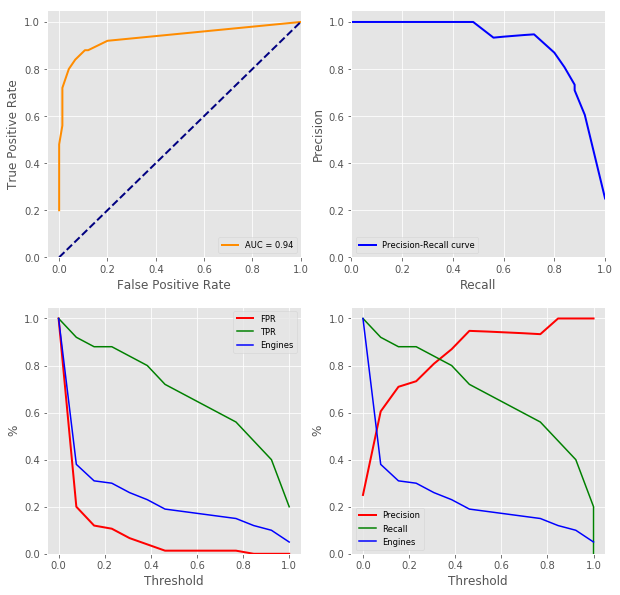

In [26]:
model = 'KNN B'
clf_knnb = KNeighborsClassifier(n_jobs=-1)
gs_params = {'n_neighbors': [9, 10, 11, 12, 13]}
gs_score = 'roc_auc'

clf_knnb, pred_knnb = bin_classify(model, clf_knnb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_knnb)

metrics_knnb, roc_knnb, prc_knnb = bin_class_metrics(model, y_test, pred_knnb.y_pred, pred_knnb.y_score, print_out=True, plot_out=True)


Best Parameters:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
           weights='uniform')
-----------------------------------------------------------
KNN A 

Confusion Matrix:
[[74  1]
 [ 7 18]]

Classification Report:
             precision    recall  f1-score   support

          0       0.91      0.99      0.95        75
          1       0.95      0.72      0.82        25

avg / total       0.92      0.92      0.92       100


Metrics:
              KNN A
Accuracy   0.920000
Precision  0.947368
Recall     0.720000
F1 Score   0.818182
ROC AUC    0.963467

ROC Thresholds:

    Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0    1.000000   8  17  75   0  0.32  0.000000  1.000000  0.815217  0.08
1    0.923077  12  13  75   0  0.48  0.000000  1.000000  0.852273  0.12
2    0.846154  14  10  75   0  0.56  0.000000  1.000000  0.882353  0.14
3    0.769231  15  10  75   0  0.60

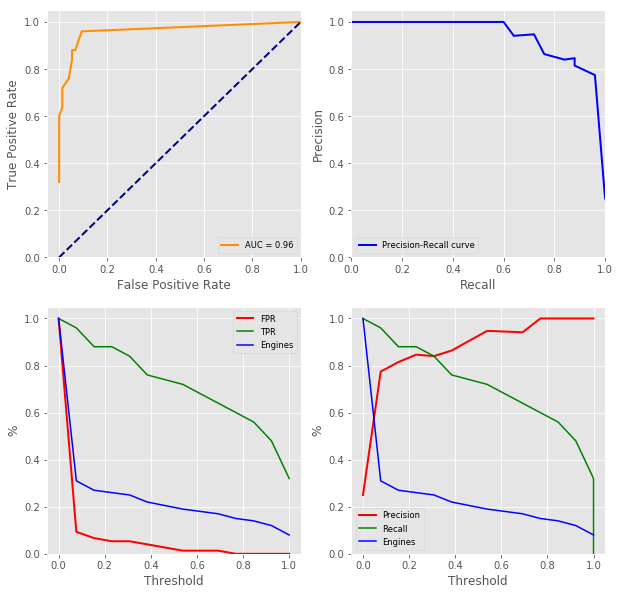

In [27]:
model = 'KNN A'
clf_knna = KNeighborsClassifier(n_jobs=-1)
gs_params = {'n_neighbors': [9 , 10, 11, 12, 13]}
gs_score = 'roc_auc'

clf_knna, pred_knna = bin_classify(model, clf_knna, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_knna)

metrics_knna, roc_knna, prc_knna = bin_class_metrics(model, y_test, pred_knna.y_pred, pred_knna.y_score, print_out=True, plot_out=True)

In [28]:
# Compare KNN Before and After FE
metrics_knn = pd.concat([metrics_knnb, metrics_knna], axis=1)
metrics_knn.sort_index()

,KNN B,KNN A
Accuracy,0.910000,0.920000
F1 Score,0.790698,0.818182
Precision,0.944444,0.947368
ROC AUC,0.935200,0.963467
Recall,0.680000,0.720000



Best Parameters:
 GaussianNB(priors=None)
-----------------------------------------------------------
Gaussian NB B 

Confusion Matrix:
[[70  5]
 [ 1 24]]

Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.93      0.96        75
          1       0.83      0.96      0.89        25

avg / total       0.95      0.94      0.94       100


Metrics:
           Gaussian NB B
Accuracy        0.940000
Precision       0.827586
Recall          0.960000
F1 Score        0.888889
ROC AUC         0.987733

ROC Thresholds:

       Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0   1.000000e+00   8  17  75   0  0.32  0.000000  1.000000  0.815217  0.08
1   1.000000e+00  17   8  75   0  0.68  0.000000  1.000000  0.903614  0.17
2   1.000000e+00  17   8  74   1  0.68  0.013333  0.986667  0.902439  0.18
3   9.999983e-01  18   7  74   1  0.72  0.013333  0.986667  0.913580  0.19
4   9.999972e-01  18   7  73   2  0.72  0.026667  0.

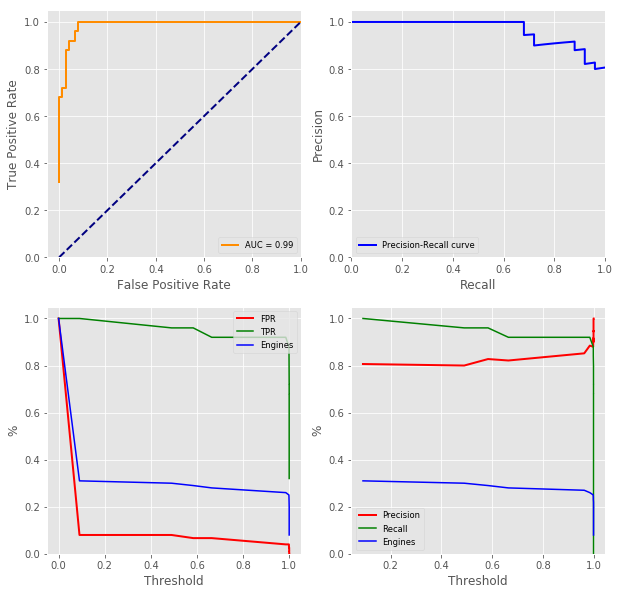

In [29]:
model = 'Gaussian NB B'
clf_gnbb = GaussianNB()
gs_params = {} 
gs_score = 'roc_auc'

clf_gnbb, pred_gnbb = bin_classify(model, clf_gnbb, features_orig, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_gnbb)

metrics_gnbb, roc_gnbb, prc_gnbb = bin_class_metrics(model, y_test, pred_gnbb.y_pred, pred_gnbb.y_score, print_out=True, plot_out=True)


Best Parameters:
 GaussianNB(priors=None)
-----------------------------------------------------------
Gaussian NB A 

Confusion Matrix:
[[70  5]
 [ 1 24]]

Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.93      0.96        75
          1       0.83      0.96      0.89        25

avg / total       0.95      0.94      0.94       100


Metrics:
           Gaussian NB A
Accuracy        0.940000
Precision       0.827586
Recall          0.960000
F1 Score        0.888889
ROC AUC         0.980533

ROC Thresholds:

       Threshold  TP  FP  TN  FN   TPR       FPR       TNR       FNR   Que
0   2.000000e+00   0  25  75   0  0.00  0.000000  1.000000  0.750000  0.00
1   1.000000e+00  17   8  74   1  0.68  0.013333  0.986667  0.902439  0.18
2   1.000000e+00  20   5  74   1  0.80  0.013333  0.986667  0.936709  0.21
3   9.999630e-01  20   5  71   4  0.80  0.053333  0.946667  0.934211  0.24
4   9.697437e-01  24   1  71   4  0.96  0.053333  0.

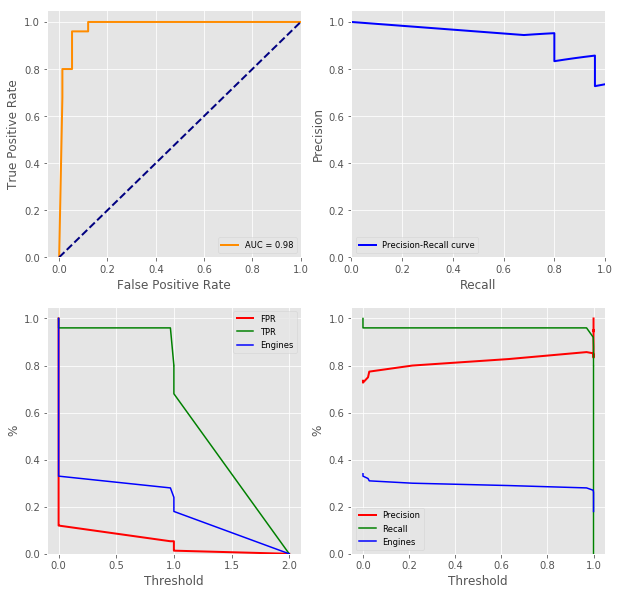

In [30]:
model = 'Gaussian NB A'
clf_gnba = GaussianNB()
gs_params = {} 
gs_score = 'roc_auc'

clf_gnba, pred_gnba = bin_classify(model, clf_gnba, features_extr, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_gnba)

metrics_gnba, roc_gnba, prc_gnba = bin_class_metrics(model, y_test, pred_gnba.y_pred, pred_gnba.y_score, print_out=True, plot_out=True)


In [31]:
# Compare Naive Bayes Before and After FE
metrics_gnb = pd.concat([metrics_gnbb, metrics_gnba], axis=1)
metrics_gnb.sort_index()

,Gaussian NB B,Gaussian NB A
Accuracy,0.940000,0.940000
F1 Score,0.888889,0.888889
Precision,0.827586,0.827586
ROC AUC,0.987733,0.980533
Recall,0.960000,0.960000


In [32]:
#compare all models
metrics_bn = pd.concat([metrics_lgr, metrics_dtr, metrics_rfc, metrics_svc, metrics_svl, metrics_knn, metrics_gnb], axis=1)
metrics_bn

,Logistic Regression B,Logistic Regression A,Decision Tree B,Decision Tree A,Random Forest B,Random Forest A,SVC B,SVC A,SVC Linear B,SVC Linear A,KNN B,KNN A,Gaussian NB B,Gaussian NB A
Accuracy,0.870000,0.920000,0.880000,0.920000,0.910000,0.910000,0.910000,0.920000,0.850000,0.670000,0.910000,0.920000,0.940000,0.940000
Precision,0.875000,1.000000,0.933333,0.947368,0.944444,0.944444,0.944444,0.947368,1.000000,0.431034,0.944444,0.947368,0.827586,0.827586
Recall,0.560000,0.680000,0.560000,0.720000,0.680000,0.680000,0.680000,0.720000,0.400000,1.000000,0.680000,0.720000,0.960000,0.960000
F1 Score,0.682927,0.809524,0.700000,0.818182,0.790698,0.790698,0.790698,0.818182,0.571429,0.602410,0.790698,0.818182,0.888889,0.888889
ROC AUC,0.980267,0.981867,0.945067,0.962933,0.980267,0.982400,0.891733,0.930133,0.971733,0.979733,0.935200,0.963467,0.987733,0.980533


Text(0.5,1,'Precision Recall Curve')

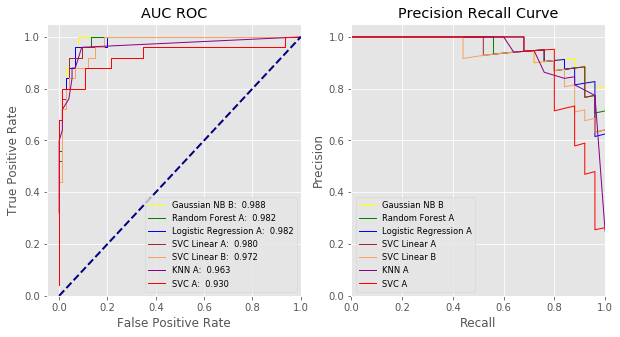

In [33]:
# Plot AUC-ROC and precision-recall curves for best models

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
fig.set_size_inches(10,5)

ax1.plot(roc_gnbb.FPR, roc_gnbb.TPR, color='yellow', lw=1, label= metrics_gnbb.columns.values.tolist()[0] + ':  %.3f' % metrics_gnbb.at['ROC AUC', metrics_gnbb.columns.values.tolist()[0]])
ax1.plot(roc_rfca.FPR, roc_rfca.TPR, color='green', lw=1, label= metrics_rfca.columns.values.tolist()[0] + ':  %.3f' % metrics_rfca.at['ROC AUC', metrics_rfca.columns.values.tolist()[0]])
ax1.plot(roc_lgra.FPR, roc_lgra.TPR, color='blue', lw=1, label= metrics_lgra.columns.values.tolist()[0] + ':  %.3f' % metrics_lgra.at['ROC AUC', metrics_lgra.columns.values.tolist()[0]])
ax1.plot(roc_svla.FPR, roc_svla.TPR, color='brown', lw=1, label= metrics_svla.columns.values.tolist()[0] + ':  %.3f' % metrics_svla.at['ROC AUC', metrics_svla.columns.values.tolist()[0]])
ax1.plot(roc_svlb.FPR, roc_svlb.TPR, color='sandybrown', lw=1, label= metrics_svlb.columns.values.tolist()[0] + ':  %.3f' % metrics_svlb.at['ROC AUC', metrics_svlb.columns.values.tolist()[0]])
ax1.plot(roc_knna.FPR, roc_knna.TPR, color='darkmagenta', lw=1, label= metrics_knna.columns.values.tolist()[0] + ':  %.3f' % metrics_knna.at['ROC AUC', metrics_knna.columns.values.tolist()[0]])
ax1.plot(roc_svca.FPR, roc_svca.TPR, color='red', lw=1, label= metrics_svca.columns.values.tolist()[0] + ':  %.3f' % metrics_svca.at['ROC AUC', metrics_svca.columns.values.tolist()[0]])
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([-0.05, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc="lower right", fontsize='small')
ax1.set_title('AUC ROC')

ax2.plot(prc_gnbb.Recall, prc_gnbb.Precision, color='yellow', lw=1, label= metrics_gnbb.columns.values.tolist()[0])
ax2.plot(prc_rfca.Recall, prc_rfca.Precision, color='green', lw=1, label= metrics_rfca.columns.values.tolist()[0])
ax2.plot(prc_lgra.Recall, prc_lgra.Precision, color='blue', lw=1, label= metrics_lgra.columns.values.tolist()[0])
ax2.plot(prc_svla.Recall, prc_svla.Precision, color='brown', lw=1, label= metrics_svla.columns.values.tolist()[0])
ax2.plot(prc_svlb.Recall, prc_svlb.Precision, color='sandybrown', lw=1, label= metrics_svlb.columns.values.tolist()[0])
ax2.plot(prc_knna.Recall, prc_knna.Precision, color='darkmagenta', lw=1, label= metrics_knna.columns.values.tolist()[0])
ax2.plot(prc_svca.Recall, prc_svca.Precision, color='red', lw=1, label= metrics_svca.columns.values.tolist()[0])
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc="lower left", fontsize='small')
ax2.set_title('Precision Recall Curve')
        

#### _Expected Profit = Prop(+ve) x [TPR x benefit(TP) + FNR x cost(FN)] + Prob(-ve) x [TNR x benefit(TN) + FPR x cost(FP)] _

Cost-benefit matrix should be designed by domain expert. Let us assume the following:  

- True Positive (TP) has benefit of USD 300K:  engines that need maintenance and correctly selected by the model.  
- True Negative (TN) has benefit of USD 0K: engines that are OK and not selected by the model.
- False Positive (FP) has cost of USD -100K: engines that are OK but selected by the model.
- False Negative (FN) has cost of USD -200K: engines that need maintenance but not selected by the model.

No. of positive class instances in the test data = 25  
No. of negative class instances in the test data = 75

In [34]:
TPb = 300
TNb = 0
FPc = -100
FNc = -200

prob_positive = 0.25 
prop_negative = 0.75

In [35]:
df_max_profit = pd.DataFrame()

roc_dfs = [roc_lgrb, roc_lgra, roc_dtrb, roc_dtra, roc_rfcb, roc_rfca, roc_svcb, roc_svca, roc_svlb, roc_svla, roc_knnb, roc_knna, roc_gnbb, roc_gnba]

for df in roc_dfs:
    df['Profit'] = prob_positive*(df.TPR*TPb + df.FNR*FNc) + prop_negative*(df.TNR*TNb + df.FPR*FPc)
    df_max = df[df.Profit == df.Profit.max()]
    df_max_profit = pd.concat([df_max_profit,df_max], ignore_index=True)
    
colnames = ['Profit', 'Model', 'Que', 'Threshold', 'TP', 'FP', 'TN', 'FN', 'TPR', 'FPR', 'TNR', 'FNR']

# sort results by Profit
df_max_profit = df_max_profit[colnames].sort_values(by='Profit', ascending=False).reset_index(drop=True)
df_max_profit


,Profit,Model,Que,Threshold,TP,FP,TN,FN,TPR,FPR,TNR,FNR
0,19.000000,Gaussian NB B,0.31,0.090529,25,0,69,6,1.00,0.080000,0.920000,1.000000
1,18.694444,Logistic Regression B,0.28,0.118426,24,1,71,4,0.96,0.053333,0.946667,0.986111
2,18.694444,Gaussian NB A,0.28,0.969744,24,1,71,4,0.96,0.053333,0.946667,0.986111
3,17.704225,Logistic Regression A,0.29,0.063386,24,1,70,5,0.96,0.066667,0.933333,0.985915
4,17.351351,Random Forest A,0.26,0.179746,23,2,72,3,0.92,0.040000,0.960000,0.972973
5,17.351351,SVC Linear A,0.26,0.777863,23,2,72,3,0.92,0.040000,0.960000,0.972973
6,17.000000,Random Forest B,0.33,0.097536,25,0,67,8,1.00,0.106667,0.893333,1.000000
7,15.724638,KNN A,0.31,0.076923,24,1,68,7,0.96,0.093333,0.906667,0.985507
8,13.054795,SVC Linear B,0.27,-0.594239,22,3,70,5,0.88,0.066667,0.933333,0.958904
9,12.164557,SVC A,0.21,-0.227728,20,5,74,1,0.80,0.013333,0.986667,0.936709


In [36]:
# sort the results by Que (capacity) and Profit

df_max_profit = df_max_profit[colnames].sort_values(by=['Que', 'Profit'], ascending=[True, False]).reset_index(drop=True)
df_max_profit

,Profit,Model,Que,Threshold,TP,FP,TN,FN,TPR,FPR,TNR,FNR
0,12.164557,SVC A,0.21,-0.227728,20,5,74,1,0.80,0.013333,0.986667,0.936709
1,17.351351,Random Forest A,0.26,0.179746,23,2,72,3,0.92,0.040000,0.960000,0.972973
2,17.351351,SVC Linear A,0.26,0.777863,23,2,72,3,0.92,0.040000,0.960000,0.972973
3,10.702703,KNN B,0.26,0.307692,21,4,70,5,0.84,0.066667,0.933333,0.945946
4,13.054795,SVC Linear B,0.27,-0.594239,22,3,70,5,0.88,0.066667,0.933333,0.958904
5,18.694444,Logistic Regression B,0.28,0.118426,24,1,71,4,0.96,0.053333,0.946667,0.986111
6,18.694444,Gaussian NB A,0.28,0.969744,24,1,71,4,0.96,0.053333,0.946667,0.986111
7,12.083333,SVC B,0.28,-0.935790,22,3,69,6,0.88,0.080000,0.920000,0.958333
8,17.704225,Logistic Regression A,0.29,0.063386,24,1,70,5,0.96,0.066667,0.933333,0.985915
9,7.816901,Decision Tree B,0.29,0.082857,21,4,67,8,0.84,0.106667,0.893333,0.943662
